Missing Values:
 satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64


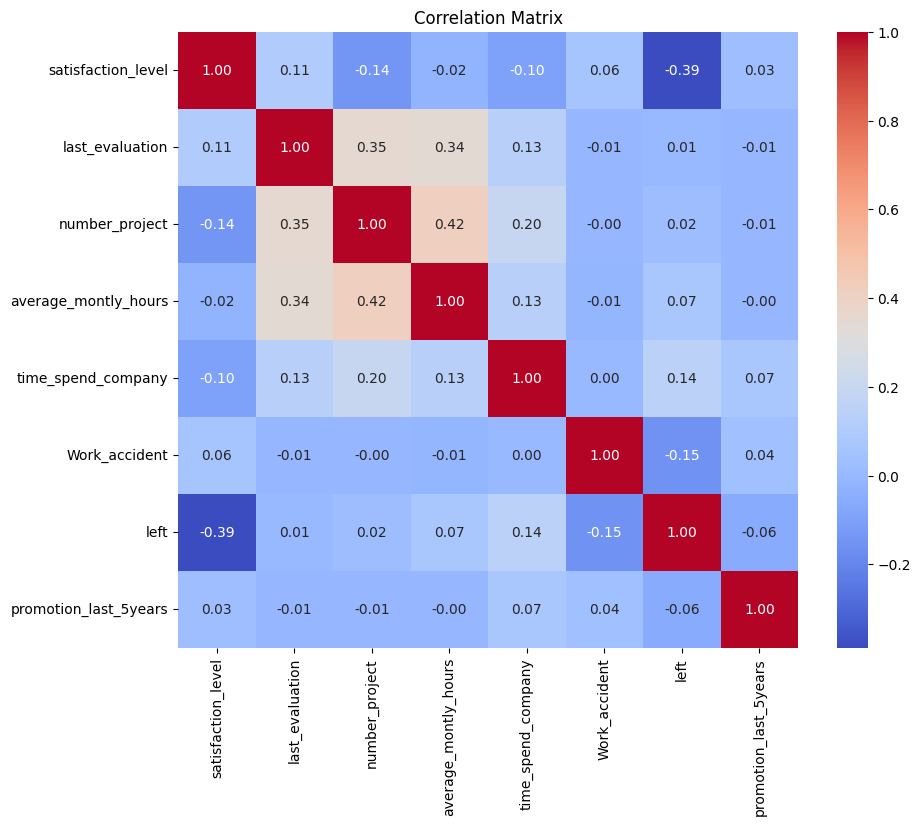

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Step 1: Perform data quality check by checking for missing values
employee_data = pd.read_csv("employee_data.csv")
missing_values = employee_data.isnull().sum()
print("Missing Values:\n", missing_values)

# Step 2: Understand what factors contributed most to employee turnover by EDA
#2.1. Draw a heatmap of the Correlation Matrix between all numerical features/columns in the data
#numeric_data = employee_data.select_dtypes(include=['int64', 'float64'])  # Select only numeric columns
#correlation_matrix = numeric_data.corr()


# Exclude non-numeric columns from the correlation computation
numeric_columns = employee_data.select_dtypes(include=['int64', 'float64']).columns

# Compute the correlation matrix using only the numeric columns
correlation_matrix = employee_data[numeric_columns].corr()

#correlation_matrix = employee_data.corr() This throws error: ValueError: could not convert string to float: 'sales' 
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()




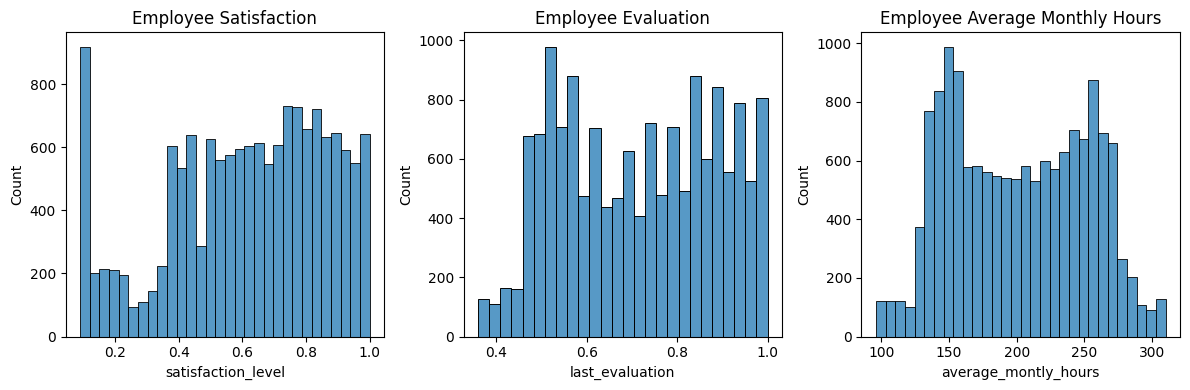

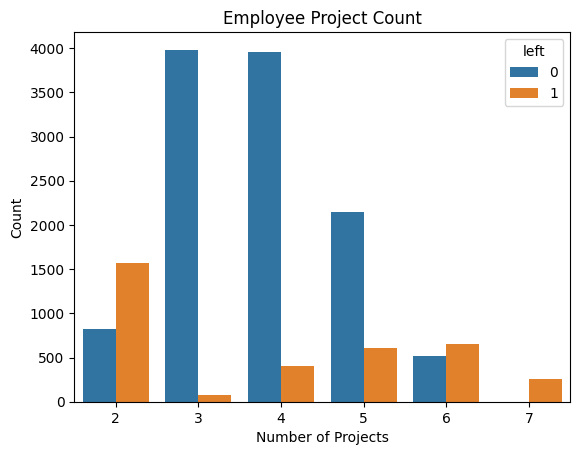

In [2]:
# Step 2.2: Draw the distribution plot of Employee Satisfaction, Evaluation, and Average Monthly Hours.
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(employee_data['satisfaction_level'].astype(float), kde=False)
plt.title('Employee Satisfaction')
plt.subplot(1, 3, 2)
sns.histplot(employee_data['last_evaluation'].astype(float), kde=False)
plt.title('Employee Evaluation')
plt.subplot(1, 3, 3)
sns.histplot(employee_data['average_montly_hours'].astype(float), kde=False)
plt.title('Employee Average Monthly Hours')
plt.tight_layout()
plt.show()

# 2.3. Draw the bar plot of Employee Project Count of both employees who left and who stayed
sns.countplot(x='number_project', data=employee_data, hue='left')
plt.title("Employee Project Count")
plt.xlabel("Number of Projects")
plt.ylabel("Count")
plt.show()


C:\Users\bh010\AppData\Local\Temp\ipykernel_348\1635484491.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_employees['cluster'] = kmeans.fit_predict(X_left)


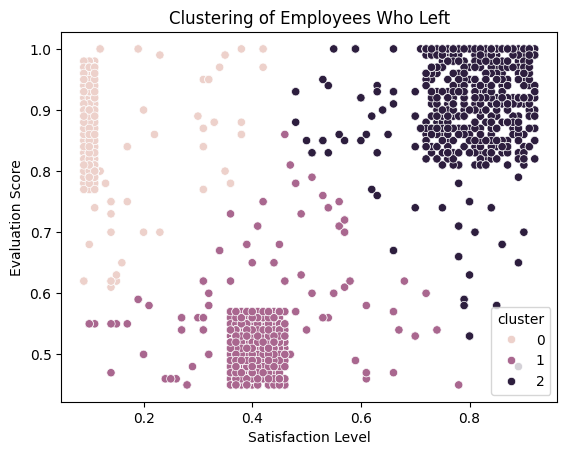

In [3]:
# Step 3: Perform clustering of Employees who left based on their satisfaction and evaluation
left_employees = employee_data[employee_data['left'] == 1]
X_left = left_employees[['satisfaction_level', 'last_evaluation']]
kmeans = KMeans(n_clusters=3, random_state=123)
left_employees['cluster'] = kmeans.fit_predict(X_left)
sns.scatterplot(x='satisfaction_level', y='last_evaluation', hue='cluster', data=left_employees)
plt.title("Clustering of Employees Who Left")
plt.xlabel("Satisfaction Level")
plt.ylabel("Evaluation Score")
plt.show()


In [4]:
# Step 4: Handle the left Class Imbalance using SMOTE technique

# Separate categorical and numeric variables
categorical_columns = ['sales', 'salary']
numeric_columns = ['satisfaction_level', 'last_evaluation', 'average_montly_hours', 'time_spend_company', 'number_project']

# Convert categorical variables to numerical using get_dummies()
X = pd.get_dummies(employee_data[categorical_columns], drop_first=True)

X[numeric_columns] = employee_data[numeric_columns]
y = employee_data['left']

# Split of dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('what is the value of scaler',scaler, 'X value',X, y, 'y value', y)
smote = SMOTE(random_state=123)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

what is the value of scaler StandardScaler() X value        sales_RandD  sales_accounting  sales_hr  sales_management  \
0            False             False     False             False   
1            False             False     False             False   
2            False             False     False             False   
3            False             False     False             False   
4            False             False     False             False   
...            ...               ...       ...               ...   
14994        False             False     False             False   
14995        False             False     False             False   
14996        False             False     False             False   
14997        False             False     False             False   
14998        False             False     False             False   

       sales_marketing  sales_product_mng  sales_sales  sales_support  \
0                False              False         True   

In [5]:
# Step 5: Perform 5-Fold cross-validation model training and evaluate performance
# 5.1. Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
logistic_cv_scores = cross_val_score(logistic_model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
logistic_cv_report = classification_report(y_train_resampled, cross_val_predict(logistic_model, X_train_resampled, y_train_resampled, cv=5))
print("Logistic Regression CV Accuracy:", logistic_cv_scores.mean())
print("Logistic Regression CV Classification Report:\n", logistic_cv_report)

# 5.2. Random Forest Classifier
rf_model = RandomForestClassifier(random_state=123)
rf_cv_scores = cross_val_score(rf_model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
rf_cv_report = classification_report(y_train_resampled, cross_val_predict(rf_model, X_train_resampled, y_train_resampled, cv=5))
print("Random Forest Classifier CV Accuracy:", rf_cv_scores.mean())
print("Random Forest Classifier CV Classification Report:\n", rf_cv_report)

# 5.3. Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=123)
gb_cv_scores = cross_val_score(gb_model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
gb_cv_report = classification_report(y_train_resampled, cross_val_predict(gb_model, X_train_resampled, y_train_resampled, cv=5))
print("Gradient Boosting Classifier CV Accuracy:", gb_cv_scores.mean())
print("Gradient Boosting Classifier CV Classification Report:\n", gb_cv_report)

Logistic Regression CV Accuracy: 0.7650406522307567
Logistic Regression CV Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.74      0.76      9142
           1       0.75      0.80      0.77      9142

    accuracy                           0.77     18284
   macro avg       0.77      0.77      0.76     18284
weighted avg       0.77      0.77      0.76     18284

Random Forest Classifier CV Accuracy: 0.987366125574346
Random Forest Classifier CV Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      9142
           1       1.00      0.98      0.99      9142

    accuracy                           0.99     18284
   macro avg       0.99      0.99      0.99     18284
weighted avg       0.99      0.99      0.99     18284

Gradient Boosting Classifier CV Accuracy: 0.9665279530458957
Gradient Boosting Classifier CV Classification Report:
               precisio

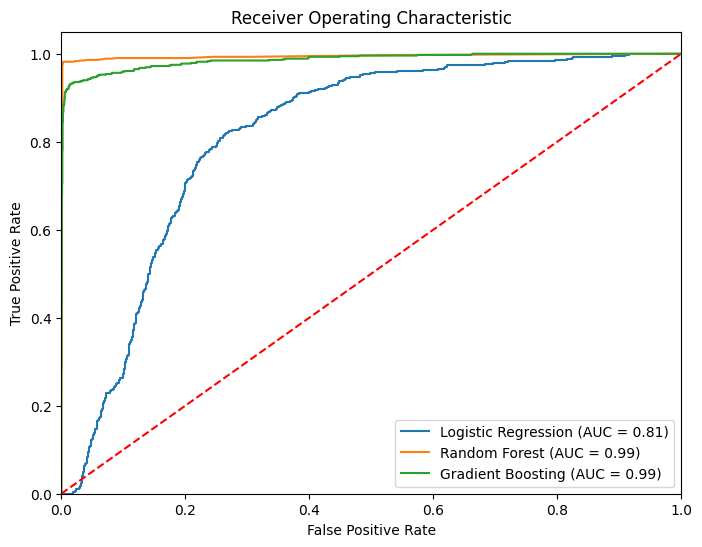

In [6]:
# Step 6: Identify the best model and justify the evaluation metrics used
# You can choose the best model based on CV accuracy or other evaluation metrics like F1-score, ROC AUC, etc.

# Step 6.1: Find the ROC/AUC for each model and plot the ROC curve
from sklearn.metrics import roc_curve
plt.figure(figsize=(8, 6))

# Logistic Regression
logistic_model.fit(X_train_resampled, y_train_resampled)
logistic_roc_auc = roc_auc_score(y_test, logistic_model.predict_proba(X_test_scaled)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, logistic_model.predict_proba(X_test_scaled)[:, 1])
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % logistic_roc_auc)

# Random Forest Classifier
rf_model.fit(X_train_resampled, y_train_resampled)
rf_roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])
plt.plot(fpr, tpr, label='Random Forest (AUC = %0.2f)' % rf_roc_auc)

# Gradient Boosting Classifier
gb_model.fit(X_train_resampled, y_train_resampled)
gb_roc_auc = roc_auc_score(y_test, gb_model.predict_proba(X_test_scaled)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, gb_model.predict_proba(X_test_scaled)[:, 1])
plt.plot(fpr, tpr, label='Gradient Boosting (AUC = %0.2f)' % gb_roc_auc)

plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [7]:
# Step 6.2: Find the confusion matrix for each of the models

def calculate_metrics(confusion_matrix):
    tn, fp, fn, tp = confusion_matrix.ravel()
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    return recall, precision

models = [logistic_model, rf_model, gb_model]
for index, model in enumerate(models):
    model.fit(X_train_resampled, y_train_resampled)
   # y_pred = model.predict(X_test_scaled)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    #print(cm)   
    if index == 0:
        print('This is for logistic_model confusion matrix:', cm)
    elif index == 1:
        print('This is for rf_model confusion matrix:', cm)
    else:
        print('This is for gb_model confusion matrix:', cm)
    
    recall_logistic, precision_logistic = calculate_metrics(cm)
    if recall_logistic > precision_logistic:
        print("The logistic regression model should prioritize Recall.\n")
    else:
        print("The logistic regression model should prioritize Precision.\n")

C:\Users\bh010\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


This is for logistic_model confusion matrix: [[   0 2286]
 [   0  714]]
The logistic regression model should prioritize Recall.



C:\Users\bh010\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


This is for rf_model confusion matrix: [[1615  671]
 [ 643   71]]
The logistic regression model should prioritize Recall.

This is for gb_model confusion matrix: [[ 377 1909]
 [ 278  436]]
The logistic regression model should prioritize Recall.



C:\Users\bh010\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


C:\Users\bh010\AppData\Local\Temp\ipykernel_348\3111387179.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_employee_data['Probability_Score'] = y_prob
C:\Users\bh010\AppData\Local\Temp\ipykernel_348\3111387179.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_employee_data['Retention_Strategy'] = zones
C:\Users\bh010\AppData\Local\Temp\ipykernel_348\3111387179.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` 

Length of y_prob: 3000
Number of rows in employee_data DataFrame: 14999
Probability scores: [0.   0.43 0.03 ... 0.04 0.02 0.99]
Probability scores: [0.   0.43 0.03 ... 0.04 0.02 0.99]


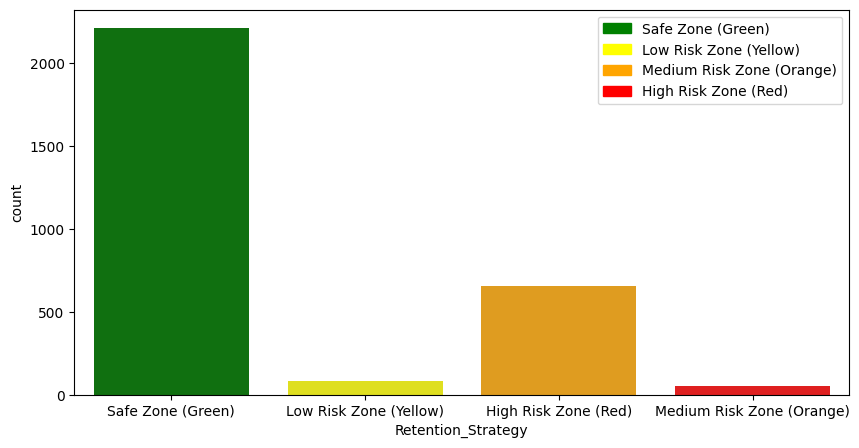

In [8]:
# Step 7: Suggest various retention strategies for targeted employees
# Using the best model, predict the probability of employee turnover in the test data
# Step 7: Suggest various retention strategies for targeted employees
# Using the best model, predict the probability of employee turnover in the test data
best_model = rf_model  # Choose the best model based on your evaluation
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Categorize employees into four zones based on probability scores
def categorize_zone(y_prob):
    if y_prob < 0.20:
        return "Safe Zone (Green)"
    elif 0.20 <= y_prob < 0.60:
        return "Low Risk Zone (Yellow)"
    elif 0.60 <= y_prob < 0.90:
        return "Medium Risk Zone (Orange)"
    else:
        return "High Risk Zone (Red)"

# Ensure the length of y_prob matches the number of rows in the test set
print("Length of y_prob:", len(y_prob))
print("Number of rows in employee_data DataFrame:", len(employee_data))

# Print the probability scores (optional)
print("Probability scores:", y_prob)

import pandas as pd

# Convert index array of X_test_scaled into pandas index
index = pd.RangeIndex(start=0, stop=len(X_test_scaled), step=1)

# Create a DataFrame for X_test_scaled with the new index
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=index)

# Ensure the length of y_prob matches the number of rows in the subset of employee_data
subset_employee_data = employee_data.iloc[X_test_scaled_df.index]

# Add the probability scores to the subset of employee_data DataFrame
subset_employee_data['Probability_Score'] = y_prob

# Print the probability scores (optional)
print("Probability scores:", y_prob)

# Apply categorize_zone function to each probability score
zones = [categorize_zone(prob) for prob in y_prob]

# Add the zones to the subset of employee_data DataFrame
subset_employee_data['Retention_Strategy'] = zones

colors = {
    "Safe Zone (Green)": "green",
    "Low Risk Zone (Yellow)": "yellow",
    "Medium Risk Zone (Orange)": "orange",
    "High Risk Zone (Red)": "red"
}


# Plot the count of employees in each zone with specified color palette
plt.figure(figsize = (10,5))
sns.countplot(x='Retention_Strategy', data=subset_employee_data, palette=colors.values())
#plt.title("Categorize employees by retention strategy")
#plt.xlabel("Retention Strategy")
#plt.ylabel("Number of Employees")

# Set legend with colors
import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=color, label=strategy) for strategy, color in colors.items()]
plt.legend(handles=handles)

plt.show()